In [4]:
# reload modules before execution (for the changing code in Src)
%load_ext autoreload
%autoreload 2

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, acovf

In [199]:
# import helper functions
import sys
import os

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
scripts_path = os.path.join(project_root, 'Src')

if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from simulate import generate_stationary_roots, compute_poly_coeffs_old, compute_poly_coeffs_new, vieta_brute_force, calculate_vietas_coeffs, generate_ar_process, Yule_Walker_solution_coeffs
from visualise import plot_roots_with_unit_circle, plot_contribution_from_roots
from utils import get_roots_hash_blake2b, serialize_roots, as_complex

# Generating a Synthetic Time Series

In time series analysis, an observed series is often represented as the sum of two main components:  

- **Systematic component** – The structured, deterministic part of the series.  
- **Residual correlated noise** – A stochastic process that may exhibit dependence over time.  

The systematic component is typically further decomposed into:

- **Trend** – The long-term directional movement in the data.  
- **Seasonality** – Regular, repeating patterns that occur at fixed intervals.  

The following approach is assumed for generating a **synthetic time series**:

1. Generating a series of **white noise**.  
2. Transforming it into a **correlated process** using an **AR($p$) model**.  
3. Adding a **trend** and **seasonality** to introduce systematic structure.  

## **White Noise**
White noise is a sequence of independent and identically distributed (i.i.d.) random variables, meaning each realization comes from the same distribution and is independent of all others. While a standard normal distribution is a common choice due to its simplicity and mathematical convenience, it is not a strict requirement. The choice of mean, variance, and even distribution is flexible, provided that the white noise remains independent and identically distributed over time.

Here, a series of white noise will be generated as i.i.d. random variables drawn from a standard normal distribution:

$$ \epsilon_t \sim \mathcal{N}(0,1) $$

## **AR($p$) Process**  

An autoregressive process of order $p$, denoted **AR($p$)**, is defined as:  

$$ X_t = \sum_{i = 1}^{p} \phi_i X_{t-i} + \epsilon_t, $$  

where $\epsilon_t$ is white noise.

The stationarity of an **AR($p$) process** is determined by the roots of its **characteristic polynomial**, which can be expressed in two equivalent formulations:  

### **1. Z-transform Representation**

Using the Z-transform, the AR($p$) process can be rewritten as:  

$$ \mathcal{Z}\{X_t\} \left( 1 - \sum_{i=1}^{p} \phi_i z^{-i} \right) = \mathcal{Z}\{\epsilon_t\}, \quad z \in \mathbb{C}. $$  

The characteristic polynomial is then given by:  

$$ 1 - \sum_{i=1}^{p} \phi_i z^{-i} = 0. $$  

Multiplying both sides by $z^p$ yields a polynomial form:  

$$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$  

For the AR($p$) process to be **stationary**, all solutions (roots) of this characteristic equation must lie **inside** the unit circle:  

$$ \forall_i \quad |z_i| < 1. $$  

For the process to remain **real-valued**, the polynomial's roots must satisfy:  

- Any complex roots must occur in **conjugate pairs**.  
- If $p$ is odd, at least one root must be **real**.  

These conditions ensure that the **coefficients** $\phi_i$ remain real.  

### **2. Backshift Operator Representation**  

The **backshift operator** $L$ is defined as:  

$$ L^k X_t = X_{t-k}. $$  

Rewriting the AR($p$) equation in terms of $L$:  

$$ \left(1 - \sum_{i=1}^{p} \phi_i L^i \right) X_t = \epsilon_t. $$  

The characteristic polynomial is then:  

$$ 1 - \sum_{i=1}^{p} \phi_i L^i = 0, $$  

which is equivalent to the Z-transform formulation, where $L$ corresponds to $z^{-1}$.  

The **stationarity condition** in this form requires that **all roots lie outside the unit circle**:  

$$ \forall_i \quad |L_i| > 1. $$  

### **Generating an AR($p$) Process**

To generate an AR($p$) process using the **Z-transform formulation**:

1. **Generate the roots ensuring stationarity**  
   Generate the roots $\{z_i\}_{i=1}^p$ of the characteristic polynomial in the **Z-transform domain**, ensuring that they lie **inside** the unit circle:

   $$ \forall_i \quad |z_i| < 1. $$

2. **Compute AR Coefficients via Vieta’s Formulas**  
   The characteristic polynomial associated with the AR($p$) process is given by:

   $$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$

   In its factored form:

   $$ \prod_{i=1}^{p} (z - z_i) = z^p + a_1 z^{p-1} + a_2 z^{p-2} + \dots + a_p = z^p - \phi_1 z^{p-1} - \phi_2 z^{p-2} - \dots - \phi_p. $$

   Expanding the left-hand side and matching coefficients term by term, the AR coefficients $\phi_i$ are obtained:

   $$ a_1 = -\sum_{i=1}^{p} z_i, $$

   $$ a_2 = \sum_{1 \le i < j \le p} z_i z_j, $$

   $$ a_3 = -\sum_{1 \le i < j < k \le p} z_i z_j z_k, $$

   and so forth, alternating signs. In general:

   $$ a_m = (-1)^{m} \sum_{1 \le i_1 < i_2 < \dots < i_m \le p} z_{i_1} z_{i_2} \dots z_{i_m}. $$

   These coefficients follow Vieta’s relations, assuming a monic polynomial (i.e., the leading coefficient is 1).

   Then $\phi_1 = -a_1$, $\phi_2 = -a_2$ and so on.

4. **Simulate the AR($p$) Process**  
   Given the computed **AR coefficients** $\phi_1, \phi_2, \dots, \phi_p$ and a **white noise process** $\{\epsilon_t\}$:

   - Initialize $X_1, \dots, X_p$ to zeros.
   - Compute:

     $$ X_t = \sum_{i=1}^{p} \phi_i X_{t-i} + \epsilon_t, \quad t = p+1, p+2, \dots $$

   - To obtain a time series of length $T$, generate $T+M$ data points and discard the first $M$ values to remove the influence of initial conditions.
   - Set $M = 10p$ to ensure minimal impact from initialization.  

This procedure yields a **stationary** AR($p$) time series $\{X_t\}$ based on the **Z-transform formulation**.

## Stationary AR(p)

### Generate roots - an example

[0.71284942+0.1236956j 0.71284942-0.1236956j 0.70701479+0.j       ]


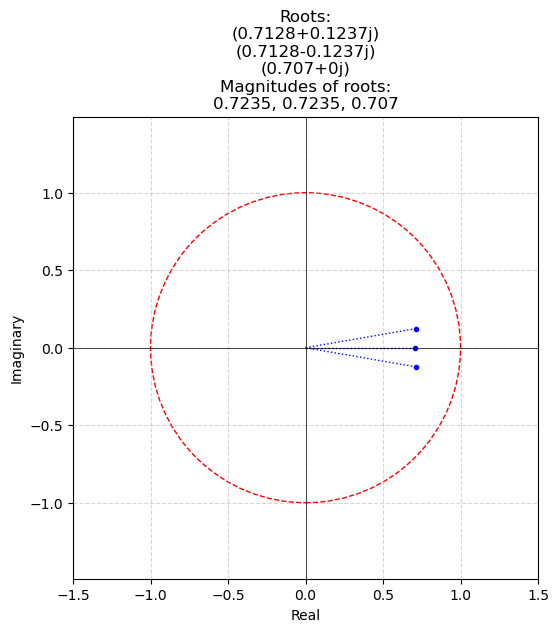

In [6]:
p = 3
roots = generate_stationary_roots(p)
print(roots)
plot_roots_with_unit_circle(roots)

### Compute coefficients

In [7]:
def check_coefs(func, root_set):
    for roots in root_set:
        print(func(roots))

In [8]:
n_runs = 1
root_set = [generate_stationary_roots(3) for _ in range(n_runs)]
for n in range(n_runs):
    check_coefs(compute_poly_coeffs_old, root_set)
    check_coefs(compute_poly_coeffs_new, root_set)
    check_coefs(calculate_vietas_coeffs, root_set)
    check_coefs(vieta_brute_force, root_set)

[-0.44028235  0.60049847 -0.19042506]
[-0.44028235+0.j  0.60049847+0.j -0.19042506+0.j]
[np.complex128(-0.4402823526140217+0j), np.complex128(0.6004984694780848+0j), np.complex128(-0.19042505535435103+0j)]
[np.complex128(-0.4402823526140217+0j), np.complex128(0.6004984694780848+0j), np.complex128(-0.19042505535435103+0j)]


### Benchmark coefficient calculating functions

In [9]:
def benchmark_function_on_fixed_roots(func, random_roots_sets):
    for roots in random_roots_sets:
        coeffs = func(roots)

In [10]:
import timeit
n_runs = 100
root_set = [generate_stationary_roots(10) for _ in range(n_runs)]

print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(vieta_brute_force, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(calculate_vietas_coeffs, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(compute_poly_coeffs_old, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(compute_poly_coeffs_new, root_set), number = n_runs))

7.228871221999725
0.27460816799793974
0.6293929220009886
1.7356658089993289


### Generate the AR(p) process driven by standard normal noise

7a20fc93852f2baabd15d0e4a296be05
Augmented Dickey-Fuller Test:
Test Statistic: -12.0509
p-value: 0.0000
Critical Values:
  1%: -3.4363
  5%: -2.8642
  10%: -2.5682
used lags: 2


KPSS Test:
Test Statistic: 0.0792
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390

KPSS Test with p provided:
Test Statistic: 0.1509
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390


/tmp/ipykernel_39057/2174816991.py:48: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(x, regression = 'c', nlags = 'auto')
/tmp/ipykernel_39057/2174816991.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_result = kpss(x, regression = 'c', nlags = p)


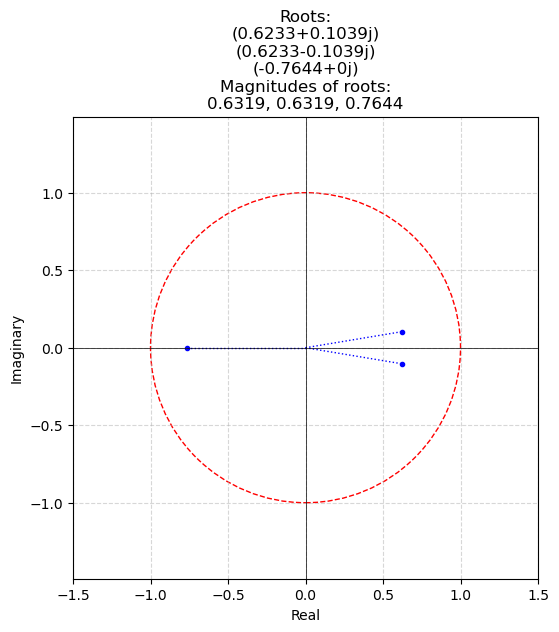

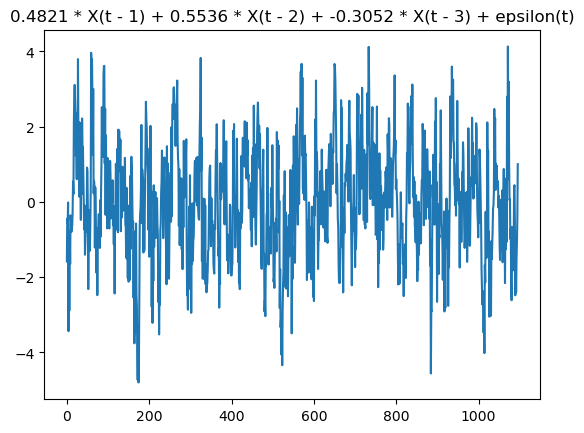

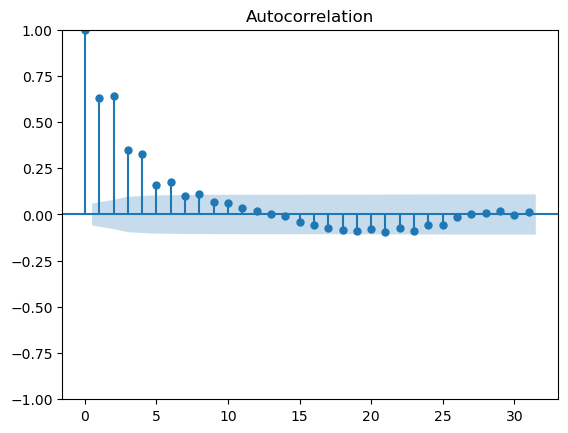

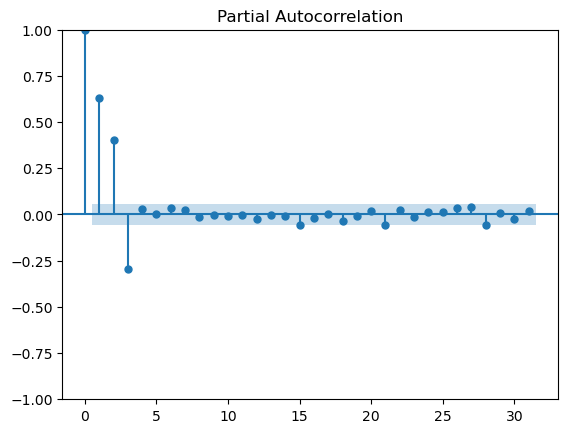

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# Y years of daily data
Y = 3
# 2020 has 366 days
N = 365 * Y + 1
start_date = pd.to_datetime("2020-01-01")
date_index = pd.date_range(start = start_date, periods = N, freq = 'D')
synth_ts = pd.DataFrame(index = date_index)

p = 3

# Generate p roots
roots = generate_stationary_roots(p)
#roots = [0.389265, 0.0553677-0.503815j, 0.0553677+0.503815j]
roots_json = serialize_roots(roots)
roots_hash = get_roots_hash_blake2b(roots)
print(roots_hash)

# Calculate characteristic polynomial coefficients
coef = calculate_vietas_coeffs(roots)

# Calculate AR coefficients
ar_coef = np.array([-c for c in coef])
# Check if all coefficients are real
if not np.all(ar_coef.imag < 10e-15):
    print("\nCoefficients are complex.\n")
    print(ar_coef)
    print("\n\n")

# Generate noise and associated AR process
x, noise = generate_ar_process(ar_coef.real, N)
synth_ts["".join(["noise_", str(p)])] = noise
synth_ts[p] = x
synth_ts.to_csv("".join(["../Data/Synthetic/", roots_hash, ".csv"]))

# Calculate ADF + KPSS
adf_result = adfuller(x, regression = 'c', maxlag = p)
print("Augmented Dickey-Fuller Test:")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")
print(f"used lags: {adf_result[2]:d}\n")

kpss_result = kpss(x, regression = 'c', nlags = 'auto')
print("\nKPSS Test:")
print(f"Test Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.4f}")

kpss_p_result = kpss(x, regression = 'c', nlags = p)
print("\nKPSS Test with p provided:")
print(f"Test Statistic: {kpss_p_result[0]:.4f}")
print(f"p-value: {kpss_p_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_p_result[3].items():
    print(f"  {key}: {value:.4f}")

# Save data
f_name = "".join(["../Data/Synthetic/", roots_hash, ".json"])
with open(f_name, 'w') as f:
    f.write(roots_json)

# Generate and save plots
f_name = "".join(["../Data/Synthetic/roots_", roots_hash, ".png"])
plot_roots_with_unit_circle(roots, f_name)

f_name = "".join(["../Data/Synthetic/series_", roots_hash, ".png"])
plt.plot(x)
ar_coef_rnd = np.round(ar_coef.real, 4)
series_title = " + ".join(["".join([str(ar_coef_rnd[i]), " * X(t - ", str(i + 1), ")"]) for i in range(len(ar_coef_rnd))]) + " + epsilon(t)"
plt.title(series_title)
plt.savefig(f_name, bbox_inches='tight')
plt.show()

f_name = "".join(["../Data/Synthetic/acf_", roots_hash, ".png"])
plot_acf(x)
plt.savefig(f_name, bbox_inches='tight')
plt.show()
f_name = "".join(["../Data/Synthetic/pacf_", roots_hash, ".png"])
plot_pacf(x)
plt.savefig(f_name, bbox_inches='tight')
plt.show()

### Load data from an already generated process

In [7]:
import json
import re
from IPython.display import Image, display

5c0f2b1d4bc5dc7ca6c1cc628d13305c
[-0.98446973-0.02606179j -0.98446973+0.02606179j -0.82077774+0.j
  0.27721076-0.54831264j  0.27721076+0.54831264j]


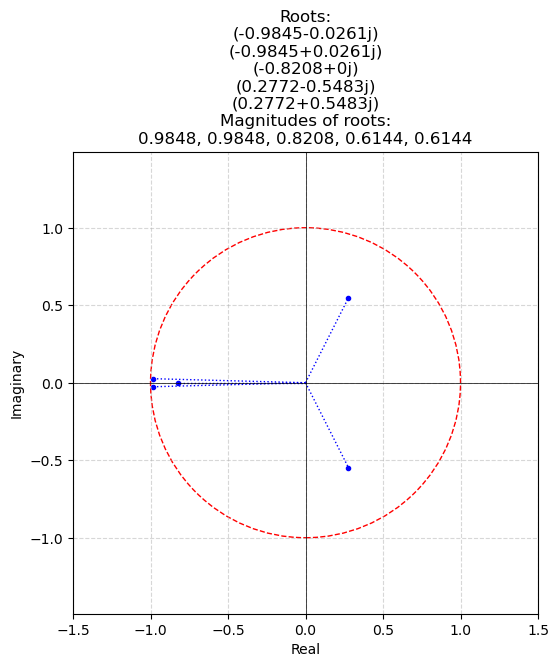

[-2.23529569-0.00000000e+00j -1.41673487-0.00000000e+00j
 -0.41544632+2.22044605e-16j -0.53482477-5.55111512e-17j
 -0.30049894-1.38777878e-17j]


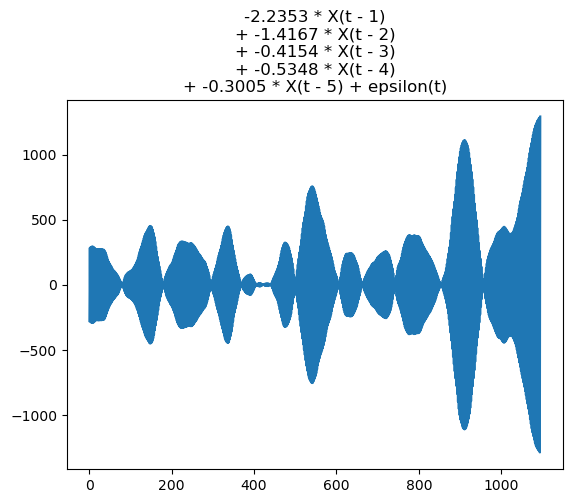

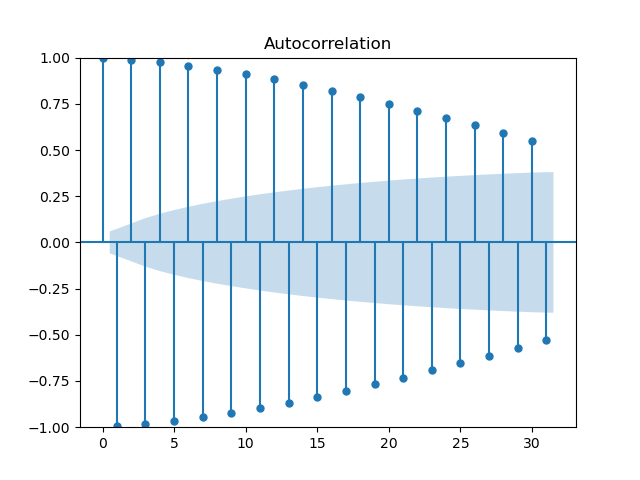

Augmented Dickey-Fuller Test:
Test Statistic: -25.1022
p-value: 0.0000
Critical Values:
  1%: -3.4364
  5%: -2.8642
  10%: -2.5682
used lags: 4


KPSS Test:
Test Statistic: 0.1208
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
used lags: 29


KPSS Test with p provided:
Test Statistic: 0.1950
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
used lags: 5



/tmp/ipykernel_39057/724851057.py:63: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(x, regression = 'c', nlags = 'auto')
/tmp/ipykernel_39057/724851057.py:72: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_result = kpss(x, regression = 'c', nlags = p)


In [147]:
series_plot_file_name = "series_5c0f2b1d4bc5dc7ca6c1cc628d13305c.png"
roots_hash = re.match(r'(series_)(.*)(.png)', series_plot_file_name).group(2)
print(roots_hash)

roots_f_name = "".join(["../Data/Synthetic/", roots_hash, ".json"])
with open(roots_f_name, 'r') as rf:
    roots_json = rf.read()
roots = np.array(json.loads(roots_json, object_hook = as_complex))
print(roots)

# Calculate characteristic polynomial coefficients
coef = calculate_vietas_coeffs(roots)

# Calculate AR coefficients
ar_coef = np.array([-c for c in coef])
# Check if all coefficients are real
if not np.all(ar_coef.imag < 10e-15):
    print("\nCoefficients are complex.\n")
    print(ar_coef)
    print("\n\n")

roots_plot_f_name = "".join(["../Data/Synthetic/roots_", roots_hash, ".png"])
#plot_roots_with_unit_circle(roots, roots_plot_f_name)
display(Image(filename=roots_plot_f_name))

print(ar_coef)

#x, noise = generate_ar_process(ar_coef.real, N)
#synth_ts["".join(["noise_", str(p)])] = noise
#synth_ts[p] = x
#synth_ts.to_csv("".join(["../Data/Synthetic/", roots_hash, ".csv"]))
synth_ts = pd.read_csv("".join(["../Data/Synthetic/", roots_hash, ".csv"]))
str_p = synth_ts.columns[-1]
x = synth_ts[str_p].values
x_long, noise_long = generate_ar_process(ar_coef.real, N * 10)

#f_name = "".join(["../Data/Synthetic/series_long_", roots_hash, ".png"])
#plt.figure(figsize = (20,5))
#plt.plot(x_long)
#ar_coef_rnd = np.round(ar_coef.real, 4)
#series_title = "\n+ ".join(["".join([str(ar_coef_rnd[i]), " * X(t - ", str(i + 1), ")"]) for i in range(len(ar_coef_rnd))]) + " + epsilon(t)"
#plt.title(series_title)
#plt.savefig(f_name, bbox_inches='tight')
#plt.show()

series_f_name = "".join(["../Data/Synthetic/series_", roots_hash, ".png"])
display(Image(filename=series_f_name))

acf_f_name = "".join(["../Data/Synthetic/acf_", roots_hash, ".png"])
display(Image(filename = acf_f_name))

p = int(str_p)
# Calculate ADF + KPSS
adf_result = adfuller(x, regression = 'c', maxlag = p)
print("Augmented Dickey-Fuller Test:")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")
print(f"used lags: {adf_result[2]:d}\n")

kpss_result = kpss(x, regression = 'c', nlags = 'auto')
print("\nKPSS Test:")
print(f"Test Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.4f}")
print(f"used lags: {kpss_result[2]:d}\n")

kpss_p_result = kpss(x, regression = 'c', nlags = p)
print("\nKPSS Test with p provided:")
print(f"Test Statistic: {kpss_p_result[0]:.4f}")
print(f"p-value: {kpss_p_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_p_result[3].items():
    print(f"  {key}: {value:.4f}")
print(f"used lags: {kpss_p_result[2]:d}\n")

# ACF analysis

In [150]:
import cmath

In [152]:
print(acovf(x_long).reshape(-1,1)[0:p])

[[ 146510.57668922]
 [-146431.51629719]
 [ 146234.37900506]
 [-145920.44918273]
 [ 145491.26965982]]


In [161]:
print(roots)
polar_v = np.vectorize(cmath.polar)
polar_v(roots)

[-0.98446973-0.02606179j -0.98446973+0.02606179j -0.82077774+0.j
  0.27721076-0.54831264j  0.27721076+0.54831264j]


(array([0.98481463, 0.98481463, 0.82077774, 0.61440423, 0.61440423]),
 array([-3.11512592,  3.11512592,  3.14159265, -1.10270217,  1.10270217]))

In [200]:
beta = Yule_Walker_solution_coeffs(roots, x_long)
print(beta)

[7.29945784e+04-4.37744133e+04j 7.29945784e+04+4.37744133e+04j
 5.21350403e+02-1.30830844e-11j 3.47063873e-02-3.49570637e-02j
 3.47063872e-02+3.49570637e-02j]


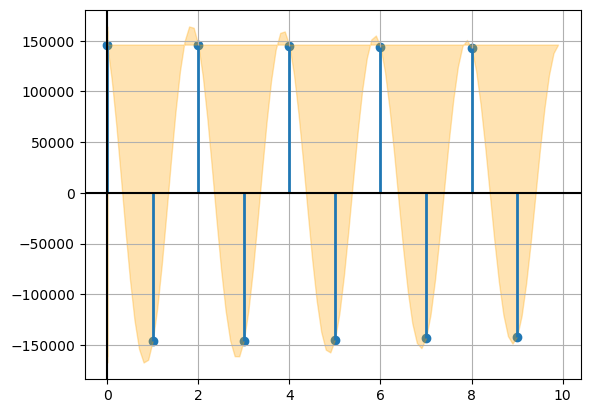

In [202]:
i = 0
radius, rangle = cmath.polar(roots[i])
bradius, bangle = cmath.polar(beta[i])
plot_contribution_from_roots(radius, rangle, bradius, bangle, 10)